In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import tensorflow as tf
import h5py, os, yaml
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns
from scipy import stats
# !pip install https://github.com/p-koo/tfomics/tarball/master
import tfomics
from test_to_bw_fast import read_model, get_config
import pandas as pd
import matplotlib.patches as patches
from tensorflow import keras
import plotly.express as px
import tfr_evaluate, util
import subprocess
import explain
from scipy.stats import pearsonr
from tqdm import tqdm
import glob
import embed
import control_shuffle as dn
from scipy.stats import pearsonr
import metrics

In [3]:
def get_GC_content(seq_array):
    return 2*seq_array[:,:,1].sum(axis=-1)/seq_array.shape[1]


In [21]:
# load and threshold data
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)
threshold = 2
cell_line = 13
thresholded_C, thresholded_X, thresholded_Y = embed.threshold_cell_line_testset(testset, cell_line)
idr_class = embed.label_idr_peaks(thresholded_C, cell_line)
predictions = embed.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)
thresholded_Y.shape

(23346, 2048)

In [9]:
low_seqs = np.load('low_seqs.npy', allow_pickle=True)
low_cov = np.load('low_cov.npy', allow_pickle=True)
low_pred = np.load('low_pred.npy', allow_pickle=True)
embeddings = np.load('embeddings.npy', allow_pickle=True)

In [295]:
embeddings = pd.DataFrame(embeddings[:,:-2], columns=['UMAP 1', 'UMAP 2', 'IDR', 'cell line'])

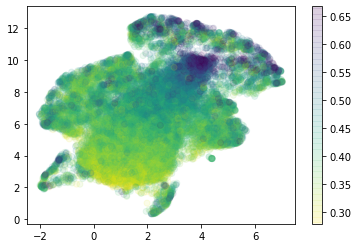

In [16]:
GC_content_all = get_GC_content(thresholded_X)
embeddings['GC content'] = GC_content_all

plt.scatter(x=embeddings['UMAP 1'], 
                y=embeddings['UMAP 2'],
                alpha=0.1,
                c=embeddings['GC content'],
               cmap='viridis_r')
plt.clim(np.percentile(GC_content_all, 1),np.percentile(GC_content_all, 99))
c = plt.colorbar()
# plt.legend(bbox_to_anchor=(1,1));

# GIA - shuffle sequences

In [695]:
# select sequences
# N = 10000
# top_N = np.argpartition(thresholded_Y.max(axis=1), -N)[-N:]
top_n = thresholded_Y.shape[0]
included_indx = []
# for each sequence decide if good enough
for i in top_N:
    pr = pearsonr(thresholded_Y[i].reshape(2048//bin_size, bin_size).mean(axis=-1), predictions[i,:,cell_line])[0]
    if (thresholded_Y[i]>2).any() and (predictions[i,:,cell_line]>2).any() and pr>0.8:
#     if (thresholded_Y[i]<5).all() and (predictions[i,:,cell_line]<5).all():
        included_indx.append(i)

In [698]:
# get original sequence preds
ori_pred = predictions[included_indx,:,cell_line]
ori_pred_max = ori_pred.max(axis=1)
# get shuffled sequence preds
shuffled_pred = []
shuffled_pred_max = []
shuffled_seqs = []
for seq_i in included_indx:
#     shuffled_seq = np.expand_dims(dinuc_shuffle(thresholded_X[seq_i,:,:]), axis=0)
    shuffled_seq = np.expand_dims(np.random.permutation(thresholded_X[seq_i,:,:]), axis=0)
    shuffled_seqs.append(shuffled_seq)
    shuffled_pred.append(model(shuffled_seq)[0,:,cell_line])
    shuffled_pred_max.append(shuffled_pred[-1].numpy().max())


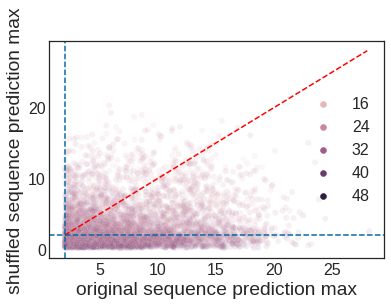

In [752]:
# compare original and shuffled preds
sns.scatterplot(x=ori_pred_max, y=shuffled_pred_max, 
            alpha=0.1, 
            hue=thresholded_X[included_indx,:,0].sum(axis=-1)/thresholded_X.shape[1]*100)
plt.xlabel('original sequence prediction max')
plt.ylabel('shuffled sequence prediction max')
x=np.arange(ori_pred_max.min(),ori_pred_max.max())
plt.plot(x,x, 'r--')
cutoff = 2
plt.axhline(cutoff, linestyle='--')
plt.axvline(cutoff, linestyle='--')


Text(0.5, 1.0, 'GC content')

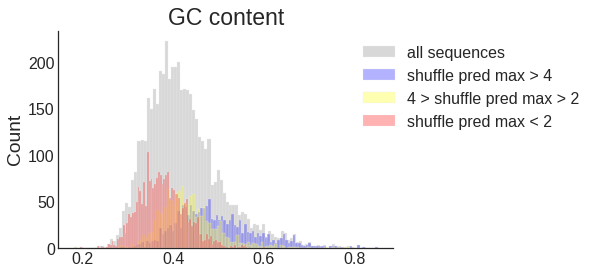

In [791]:
# compare GC contents
gc = get_GC_content(thresholded_X[included_indx])
sns.histplot(gc, bins=100, label='all sequences', 
             alpha=0.3, color='grey'
            );

gc = get_GC_content(thresholded_X[included_indx][np.array(shuffled_pred_max)>4])
sns.histplot(gc, bins=100, 
             label='shuffle pred max > 4', 
             alpha=0.3, color='blue');

gc = get_GC_content(thresholded_X[included_indx][(np.array(shuffled_pred_max)<4)&(np.array(shuffled_pred_max)>2)])
sns.histplot(gc, bins=100, 
             label='4 > shuffle pred max > 2', 
             alpha=0.3, color='yellow');

gc = get_GC_content(thresholded_X[included_indx][np.array(shuffled_pred_max)<2])
sns.histplot(gc, bins=100, 
             label='shuffle pred max < 2',
             alpha=0.3, color='red');


plt.legend(loc='upper right', bbox_to_anchor=(1.6,1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('GC content')

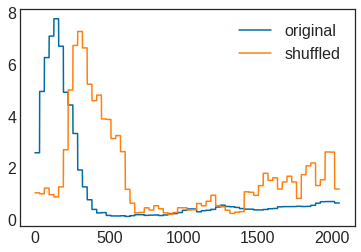

In [703]:
i = 10
above_line = np.argwhere((np.array(shuffled_pred_max)>cutoff))
#                         (np.array(ori_pred_max)<cutoff+1))
np_shuffled = np.squeeze(np.array(shuffled_pred)[above_line[i]])
np_ori = np.squeeze(np.array(ori_pred)[above_line[i]])
np_X = thresholded_X
plt.plot(np.repeat(np_ori, bin_size), label='original');
plt.plot(np.repeat(np_shuffled, bin_size), label='shuffled');
plt.legend()
# plot saliency maps
X_sample = thresholded_X[included_indx][above_line[i]]
saliency_scores = explainer.saliency_maps(X_sample)
# plot attribution maps in a narrow range about max saliency value
explain.plot_saliency_logos(saliency_scores, X_sample, window=200)
plt.title('original sequence')

X_sample = np.squeeze(np.array(shuffled_seqs))[above_line[i]]
saliency_scores = explainer.saliency_maps(X_sample)
# plot attribution maps in a narrow range about max saliency value
explain.plot_saliency_logos(saliency_scores, X_sample, window=200)
plt.title('shuffled sequence')